<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach3/Pregunta_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales II-2018

## Tarea 3- Redes Recurrentes, Autoencoders y sus aplicaciones


21/12/2018

* Rodrigo González Smith 201303026-2
* Ignacio Valenzuela Albornoz 2014073055-1

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import numpy as np
import time

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32')/255
n_train = len(x_train)
#5000 imágenes de validación
x_val = x_train[0:5000]
y_val = y_train[0:5000]
x_train = x_train[5001:]
y_train = y_train[5001:]

## 2. Autoencoders (AEs) en MNIST

En esta tarea procederemos a trabajar con autoencoders, los cuales son un método para extraer características relevantes de set de datos, por medio de aprendizaje no supervisado. Su estructura particular permite este tipo de tareas, por lo cual nos centraremos en como obtener mejor calidad respecto al error de reconstrucción, analizar distintas arquitecturas y elecciones de hiperparametros. 

## 2.1 Reducción de dimensionalidad

### 2.1.a AE básico

Ahora vamos a reducir la dimensionaldiad de las imagenes cargasdas por medio de un *autoencoder* básico.

In [0]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
dims = [2,4,8,16,32,64]

Procedemos a entrenar con las distintas dimensiones, donde posteriormente analizaremos los errores obtenidos y nos quedaremos con el que presente los mejores resultados. Tiene sentido ocupar como función de perdida a *binary cross entropy* dado que los varios output de la capa de salida, serán la reconstrucción de la imagen la cual esta normalizada, es decir ocurre que $x_i \in [0,1]$. Así el error binario se medirá para cada nodo de salida.

In [6]:
input_img = Input(shape=(784,))
autoencoder_1_a_list = list()
encoder_1_a_list = list()
history_1_a_list = list()
for i in dims:
  encoded_1_a = Dense(i, activation='sigmoid')(input_img)
  decoded_1_a = Dense(784, activation='sigmoid')(encoded_1_a)
  autoencoder_1_a = Model(input=input_img, output=decoded_1_a)
  encoder_1_a = Model(input=input_img, output=encoded_1_a)
  encoded_input_1_a = Input(shape=(i,))
  decoder_layer_1_a = autoencoder_1_a.layers[-1]
  decoder_1_a = Model(inputs=encoded_input_1_a, outputs=decoder_layer_1_a(encoded_input_1_a))
  autoencoder_1_a_list.append(autoencoder_1_a)
  autoencoder_1_a.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
  history_1_a = autoencoder_1_a.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
  history_1_a_list.append(history_1_a)
  autoencoder_1_a.save('basic_autoencoder_768x'+str(i)+'.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


Train on 54999 samples, validate on 5000 samples
Epoch 1/50
54999/54999 [==============================] - 10s 174us/step - loss: 0.4568 - acc: 0.7883 - val_loss: 0.3478 - val_acc: 0.8031
Epoch 2/50
54999/54999 [==============================] - 8s 137us/step - loss: 0.3197 - acc: 0.8039 - val_loss: 0.3017 - val_acc: 0.8043
Epoch 3/50
54999/54999 [==============================] - 7s 135us/step - loss: 0.2933 - acc: 0.8042 - val_loss: 0.2868 - val_acc: 0.8046
Epoch 4/50
54999/54999 [==============================] - 7s 134us/step - loss: 0.2830 - acc: 0.8043 - val_loss: 0.2798 - val_acc: 0.8046
Epoch 5/50
54999/54999 [==============================] - 7s 132us/step - loss: 0.2776 - acc: 0.8043 - val_loss: 0.2758 - val_acc: 0.8046
Epoch 6/50
54999/54999 [==============================] - 7s 131us/step - loss: 0.2744 - acc: 0.8043 - val_loss: 0.2732 - val_acc: 0.8046
Epoch 7/50
54999/54999 [==============================] - 7s 135us/step - loss: 0.2723 - acc: 0.8044 - val_loss: 0.2714 - 

* Graficamos los errores para cada caso,  notamos que usamos SGD como optimizador para el entrenamiento. Para ello definiremos funciones que obtendrán las métricas y posteriormente generarán los gráficos de Loss y Accuracy, para el entrenamiento  y validación por época.

In [0]:
def get_metrics_lists(history):
  loss_train,loss_val,acc_train,acc_val = list(),list(),list(),list()
  losses = [[] for i in range(2)]
  accs = [[] for i in range(2)]
  loss_train,loss_val,acc_train,acc_val = history.history['loss'],history.history['val_loss'], history.history['acc'],history.history['val_acc']
  losses[0] = loss_train
  losses[1] = loss_val
  accs[0] = acc_train
  accs[1] = acc_val
  return losses,accs

def triple_plot(losses, accs,title):
  plt.figure(num=None, figsize=(18, 4), dpi=80, facecolor='w', edgecolor='k')
  plt.subplot(1,2,1)
  plt.plot(losses[0])
  plt.plot(losses[1])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.subplot(1,2,2)
  plt.plot(accs[0])
  plt.plot(accs[1])
  plt.title(title.replace("Loss", "Accuracy"))
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()
 

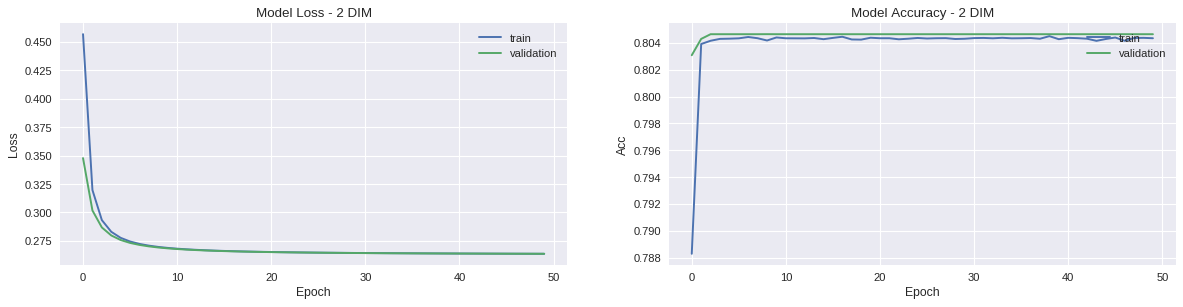

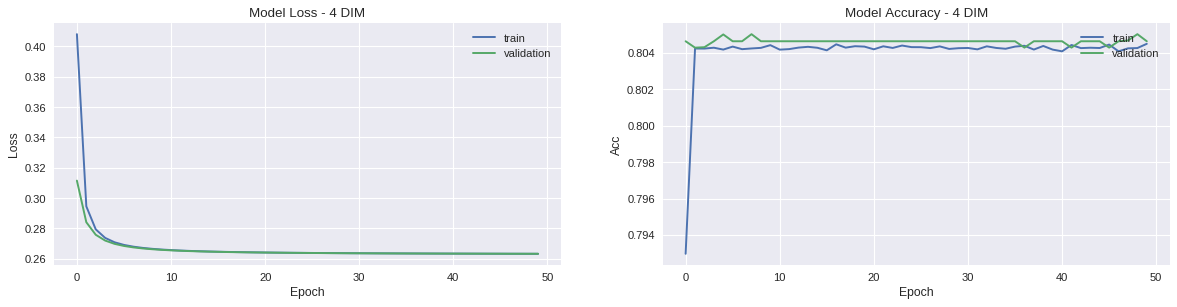

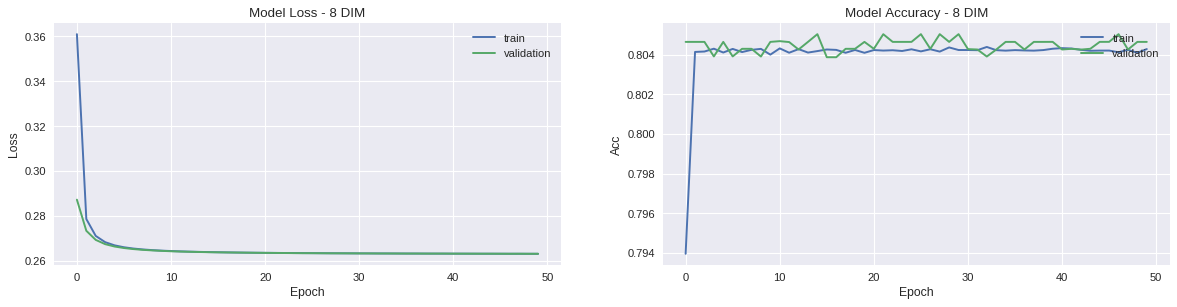

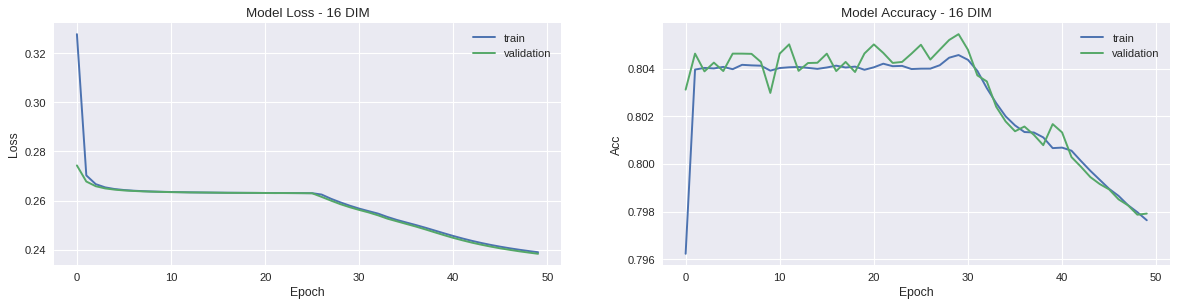

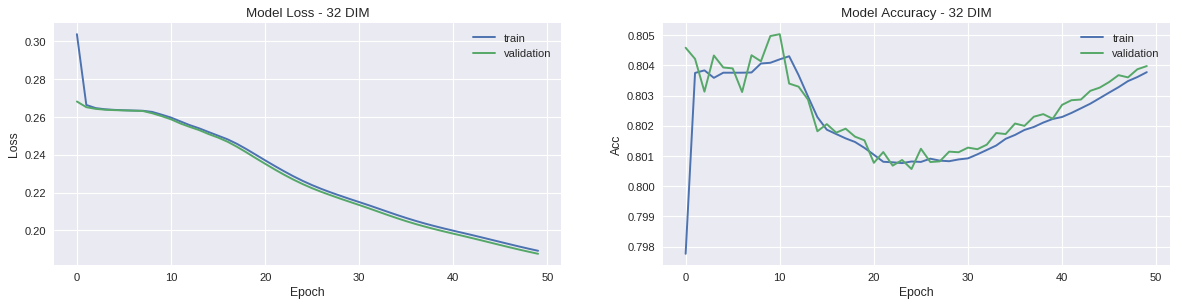

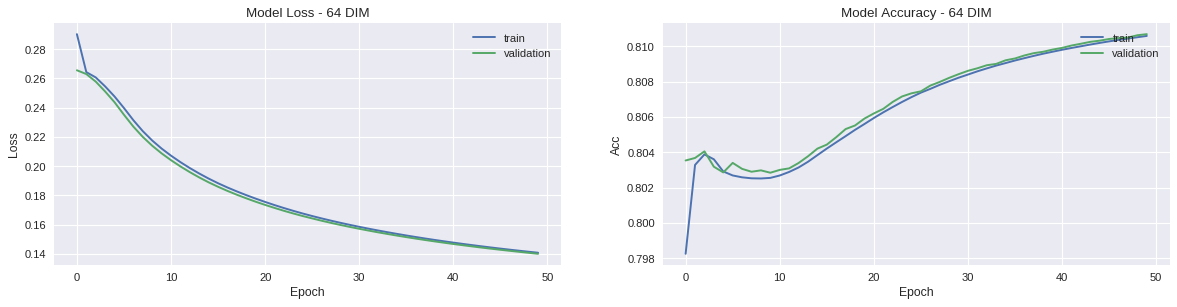

In [8]:
for i in range(len(history_1_a_list)):
  losses,accs = get_metrics_lists(history_1_a_list[i])
  triple_plot(losses,accs,'Model Loss - '+str(dims[i])+' DIM')

In [9]:
print("Porcentajes de compresión por dimensión")
for d in dims:
  print("Para una dimensión: "+ str(d) + " es " + str(round((1-d/784)*100,2)) + "%")

Porcentajes de compresión por dimensión
Para una dimensión: 2 es 99.74%
Para una dimensión: 4 es 99.49%
Para una dimensión: 8 es 98.98%
Para una dimensión: 16 es 97.96%
Para una dimensión: 32 es 95.92%
Para una dimensión: 64 es 91.84%


* Nos interesa saber también la cantidad de pesos que fueron entrenados previamente, analizamos el caso mayor (64 dimensiones) comparando con el menor (2 dimensiones):

In [10]:
autoencoder_1_a_list[0].summary()
autoencoder_1_a_list[5].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_12

*  Probamos cambiando la función de activación por una **ReLU** para el *encoder*, de manera que verificaremos si mejora el error de reconstrucción:




In [11]:
autoencoder_1_a_2_list = list()
encoder_1_a_2_list = list()
history_1_a_2_list = list()
for i in dims:
  encoded_1_a_2 = Dense(i, activation='relu')(input_img)
  decoded_1_a_2 = Dense(784, activation='sigmoid')(encoded_1_a_2)
  autoencoder_1_a_2 = Model(input=input_img, output=decoded_1_a_2)
  encoder_1_a_2 = Model(input=input_img, output=encoded_1_a_2)
  encoded_input_1_a_2 = Input(shape=(i,))
  decoder_layer_1_a_2 = autoencoder_1_a_2.layers[-1]
  decoder_1_a_2 = Model(inputs=encoded_input_1_a_2, outputs=decoder_layer_1_a_2(encoded_input_1_a_2))
  autoencoder_1_a_2_list.append(autoencoder_1_a_2)
  autoencoder_1_a_2.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
  history_1_a_2 = autoencoder_1_a_2.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
  history_1_a_2_list.append(history_1_a_2)
  encoder_1_a_2_list.append(encoder_1_a_2)
  autoencoder_1_a_2.save('basic_autoencoder_2_768x'+str(i)+'.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Train on 54999 samples, validate on 5000 samples
Epoch 1/50
54999/54999 [==============================] - 8s 140us/step - loss: 0.3053 - acc: 0.7898 - val_loss: 0.2512 - val_acc: 0.7903
Epoch 2/50
54999/54999 [==============================] - 8s 138us/step - loss: 0.2497 - acc: 0.7900 - val_loss: 0.2474 - val_acc: 0.7920
Epoch 3/50
54999/54999 [==============================] - 8s 137us/step - loss: 0.2462 - acc: 0.7910 - val_loss: 0.2447 - val_acc: 0.7885
Epoch 4/50
54999/54999 [==============================] - 7s 135us/step - loss: 0.2434 - acc: 0.7923 - val_loss: 0.2422 - val_acc: 0.7918
Epoch 5/50
54999/54999 [==============================] - 7s 133us/step - loss: 0.2415 - acc: 0.7932 - val_loss: 0.2410 - val_acc: 0.7922
Epoch 6/50
54999/54999 [==============================] - 7s 133us/step - loss: 0.2404 - acc: 0.7938 - val_loss: 0.2402 - val_acc: 0.7942
Epoch 7/50
54999/54999 [==============================] - 8s 150us/step - loss: 0.2397 - acc: 0.7942 - val_loss: 0.2399 - v

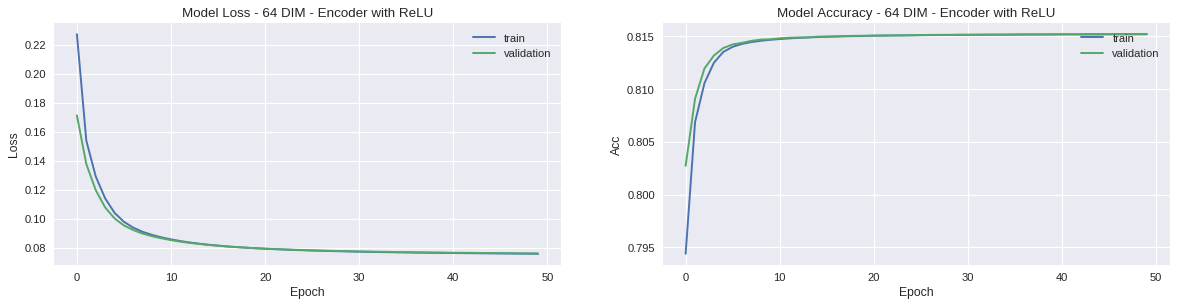

In [12]:
losses,accs = get_metrics_lists(history_1_a_2)
triple_plot(losses,accs,'Model Loss - 64 DIM - Encoder with ReLU')

* Por úiltimo utilizar la función de activación ReLU en el decoder para corroborar el porque no es adecuado. El problema principal viene respecto a que no esta acotada para x mayores a 0, por lo cual el *input* normalizado no se logra copiar correctamente, esto indica que sedebe ocupar una función de activación que este acotada en el intervalo $\in [0,1]$.

In [14]:
encoded_1_a_3 = Dense(64, activation='sigmoid')(input_img)
decoded_1_a_3 = Dense(784, activation='relu')(encoded_1_a_3)
autoencoder_1_a_3 = Model(input=input_img, output=decoded_1_a_3)
encoder_1_a_3 = Model(input=input_img, output=encoded_1_a_3)
encoded_input_1_a_3 = Input(shape=(64,))
decoder_layer_1_a_3 = autoencoder_1_a_3.layers[-1]
decoder_1_a_3 = Model(inputs=encoded_input_1_a_3, outputs=decoder_layer_1_a_3(encoded_input_1_a_3))
autoencoder_1_a_3.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history_1_a_3 = autoencoder_1_a_3.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder_1_a_3.save('basic_autoencoder_3_768x32.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


Train on 54999 samples, validate on 5000 samples
Epoch 1/50
54999/54999 [==============================] - 8s 151us/step - loss: 1.5500 - acc: 0.7488 - val_loss: 1.6647 - val_acc: 0.7367
Epoch 2/50
54999/54999 [==============================] - 8s 141us/step - loss: 2.0287 - acc: 0.7200 - val_loss: 2.3434 - val_acc: 0.7065
Epoch 3/50
54999/54999 [==============================] - 8s 140us/step - loss: 1.5527 - acc: 0.7402 - val_loss: 1.4160 - val_acc: 0.7424
Epoch 4/50
54999/54999 [==============================] - 8s 139us/step - loss: 2.1192 - acc: 0.7037 - val_loss: 2.6376 - val_acc: 0.6754
Epoch 5/50
54999/54999 [==============================] - 8s 138us/step - loss: 3.0544 - acc: 0.6547 - val_loss: 3.4710 - val_acc: 0.6341
Epoch 6/50
54999/54999 [==============================] - 8s 139us/step - loss: 3.8283 - acc: 0.6182 - val_loss: 4.1516 - val_acc: 0.6018
Epoch 7/50
54999/54999 [==============================] - 8s 139us/step - loss: 4.4423 - acc: 0.5858 - val_loss: 4.6787 - v

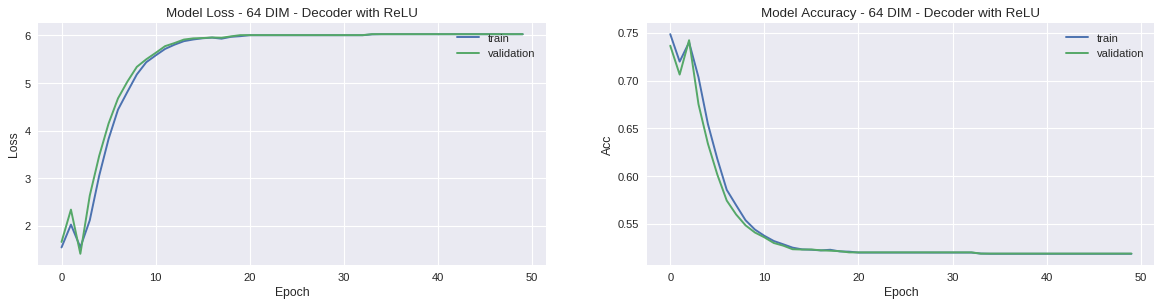

In [15]:
losses,accs = get_metrics_lists(history_1_a_3)
triple_plot(losses,accs,'Model Loss - 64 DIM - Decoder with ReLU')

### 2.1.b Reconstrucción de imágenes

* Ahora se realizará una comparación cualitativa respecto a al reconstrucción de las imágenes, compararemos con d=2,16,64. Analizando si aumentar controladamente este valor mejora la copia del Input al Output.


============================ Reconstrucción con 2 dimensiones con loss final: 0.23 y Acc: 0.8============================


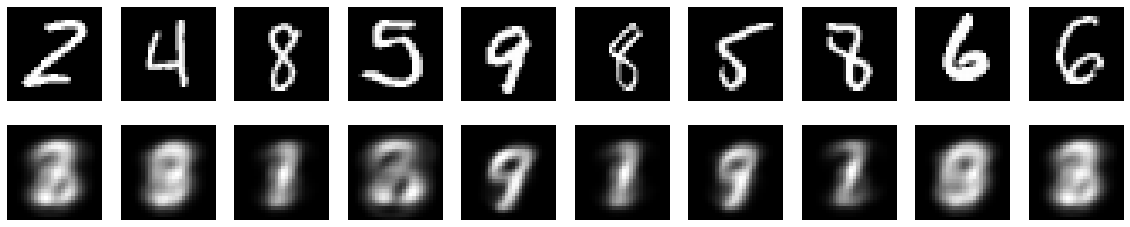

============================ Reconstrucción con 16 dimensiones con loss final: 0.13 y Acc: 0.81============================


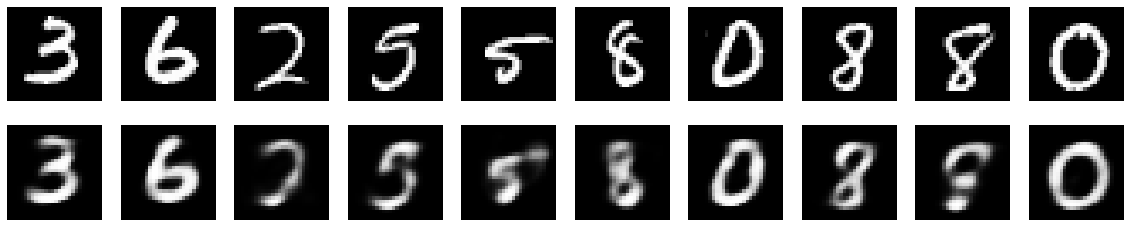

============================ Reconstrucción con 64 dimensiones con loss final: 0.08 y Acc: 0.82============================


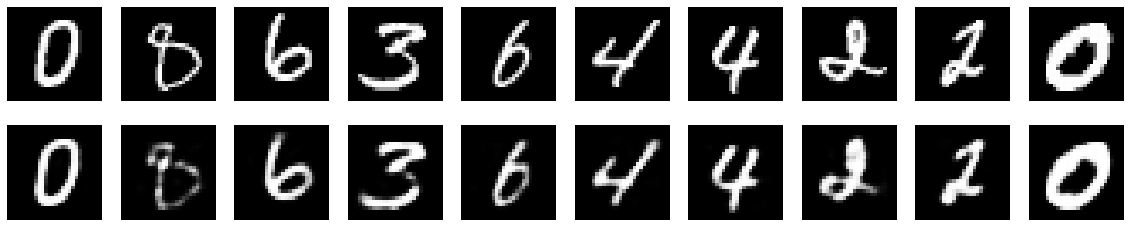

In [19]:

#autoencoder = load_model('basic_autoencoder_768x32.h5')
for i in [0,3,5]:
  print("============================ Reconstrucción con " + str(dims[i]) + " dimensiones con loss final: " + str(round(history_1_a_2_list[i].history['val_loss'][-1],2)) + " y Acc: "+ str(round(history_1_a_2_list[i].history['val_acc'][-1],2)) +"============================")
  encoded_test_1_b = encoder_1_a_2_list[i].predict(x_test)
  encoded_input_1_b_2 = Input(shape=(dims[i],))
  decoder_layer_1_b = autoencoder_1_a_2_list[i].layers[-1]
  decoder_1_b = Model(inputs=encoded_input_1_b_2, outputs=decoder_layer_1_b(encoded_input_1_b_2))
  decoded_test_1_b = decoder_1_b.predict(encoded_test_1_b)
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_test_1_b[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

Tomando en cuenta el valor del Loss de validación se puede entoncer ver que es una métrica adecuada para analizar la reconstrucción final obtenida, además como esperabamos al aumentar la dimensión y cantidad de características relevantes, la reconstrucción y copia es mejor. Es el *trade off* de exigir menos al modelo que extraiga las características más importantes de las imágenes, sin embargo esto también aumenta considerablemente el tiempo de entrenamiento final.

### 2.1.c  Comparación con PCA

* Se compara la técnica clasica de reducción dimensional PCA o *Principal Component Analysis* con nuestro encoder ya entrenado. Se utilizará el que obtuvo mejor loss, en nuestro caso al usar ReLU. Compararemos para las dimensiones $d'$= 2, 4, 8, 16, 32.

In [29]:
i=0
for dim in dims:
  print("============================ Comparación encoder vs PCA para dimensión de tamaño " + str(dim) + " ============================")
  pca_1_c = PCA(n_components=dim)
  pca_1_c.fit(x_train)
  pca_train_1_c = pca_1_c.transform(x_train)
  pca_test_1_c = pca_1_c.transform(x_test)
  #AUTOENCODER
  encoded_train_1_c = encoder_1_a_2_list[i].predict(x_train)
  encoded_test_1_c = encoder_1_a_2_list[i].predict(x_test)
  #CLASIFICATION
  clf_1_c = KNeighborsClassifier(10)
  clf_1_c.fit(pca_train_1_c, y_train)
  print('Classification Accuracy PCA: ' + str(clf_1_c.score(pca_test_1_c,y_test))) 
  clf_1_c = KNeighborsClassifier(10)
  clf_1_c.fit(encoded_train_1_c, y_train)
  print('Classification Accuracy Encoder: ' + str(clf_1_c.score(encoded_test_1_c,y_test)))
  i+=1

============================ Comparación encoder vs PCA para dimensión de tamaño 2 ============================
Classification Accuracy PCA: 0.4401
Classification Accuracy Encoder: 0.3736
============================ Comparación encoder vs PCA para dimensión de tamaño 4 ============================
Classification Accuracy PCA: 0.6463
Classification Accuracy Encoder: 0.6159
============================ Comparación encoder vs PCA para dimensión de tamaño 8 ============================
Classification Accuracy PCA: 0.905
Classification Accuracy Encoder: 0.8874
============================ Comparación encoder vs PCA para dimensión de tamaño 16 ============================
Classification Accuracy PCA: 0.9622
Classification Accuracy Encoder: 0.9552
============================ Comparación encoder vs PCA para dimensión de tamaño 32 ============================
Classification Accuracy PCA: 0.9742
Classification Accuracy Encoder: 0.9674
============================ Comparación encoder vs PCA par

### 2.1.d Deep Autoencoder

* Ahora veremos desempeño para un autoencoder con arquitectura profunda o *deep*, es natural hacer este paso dado nuestro trabajos previos. Analizaremos que tanto mejora la calidad del autoencoder,  y procederemos a realizar el mismo análisis previo correspondiente a la comparación con PCA. Usaremos $d'$= 2, 4, 8, 16, 32. dimensiones, y variaremos las profundidades en el rango $L \in [2,4]$. Analizaremos los resultados para verificar si aumentando la dimensión junto a la cantidad de capas mejora o no el error de reconstrucción.

#### 2.1.d.1 2 capas escondidas

In [44]:
dims_1_d = [2,4,8,16]
times_d_1 = list()
autoencoder_1_d_1_list = list()
encoder_1_d_1_list = list()
history_1_d_1_list = list()

for dim in dims_1_d:
  start = time.clock()
  encoded1 = Dense(1000, activation='relu')(input_img)
  encoded4 = Dense(dim, activation='relu')(encoded1)
  decoded4 = Dense(1000, activation='relu')(encoded4)
  decoded1 = Dense(784, activation='sigmoid')(decoded4)
  autoencoder = Model(input=input_img, output=decoded1)
  encoder = Model(input=input_img, output=encoded4)
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
  history_1_d =  autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_val,x_val))
  times_d_1.append(time.clock()-start)
  autoencoder_1_d_1_list.append(autoencoder)
  encoder_1_d_1_list.append(encoder)
  history_1_d_1_list.append(history_1_d)
#  autoencoder.save('my_autoencoder_768x1000x500x250x2.h5')
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Train on 54999 samples, validate on 5000 samples
Epoch 1/40
54999/54999 [==============================] - 13s 235us/step - loss: 0.2841 - acc: 0.7947 - val_loss: 0.2401 - val_acc: 0.7972
Epoch 2/40
54999/54999 [==============================] - 12s 215us/step - loss: 0.2346 - acc: 0.7954 - val_loss: 0.2307 - val_acc: 0.7922
Epoch 3/40
54999/54999 [==============================] - 12s 213us/step - loss: 0.2265 - acc: 0.7958 - val_loss: 0.2224 - val_acc: 0.7972
Epoch 4/40
54999/54999 [==============================] - 12s 213us/step - loss: 0.2202 - acc: 0.7952 - val_loss: 0.2176 - val_acc: 0.7960
Epoch 5/40
54999/54999 [==============================] - 12s 214us/step - loss: 0.2169 - acc: 0.7947 - val_loss: 0.2154 - val_acc: 0.7899
Epoch 6/40
54999/54999 [==============================] - 12s 214us/step - loss: 0.2145 - acc: 0.7949 - val_loss: 0.2128 - val_acc: 0.7931
Epoch 7/40
54999/54999 [==============================] - 12s 212us/step - loss: 0.2124 - acc: 0.7953 - val_loss: 0.2

Graficamos los resultados obtenidos para cada dimensión:

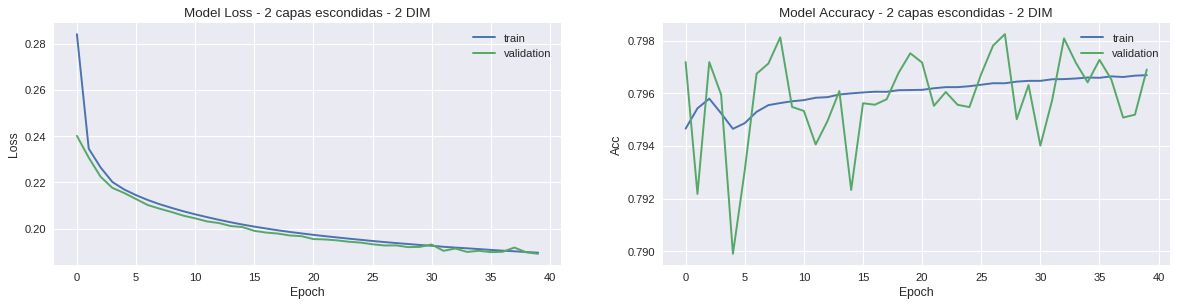

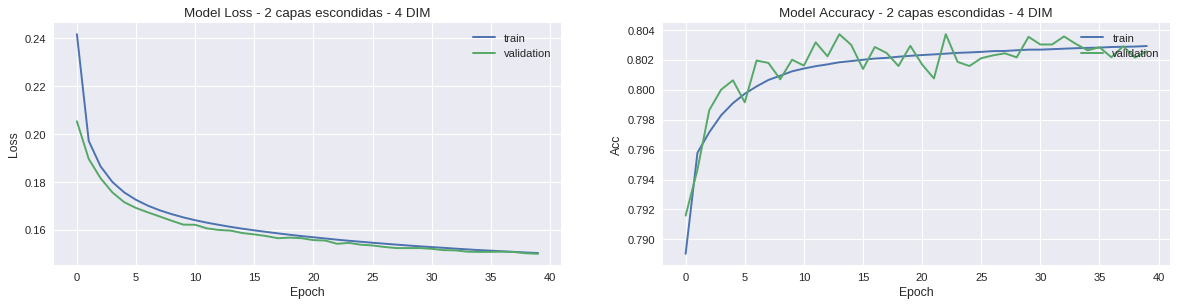

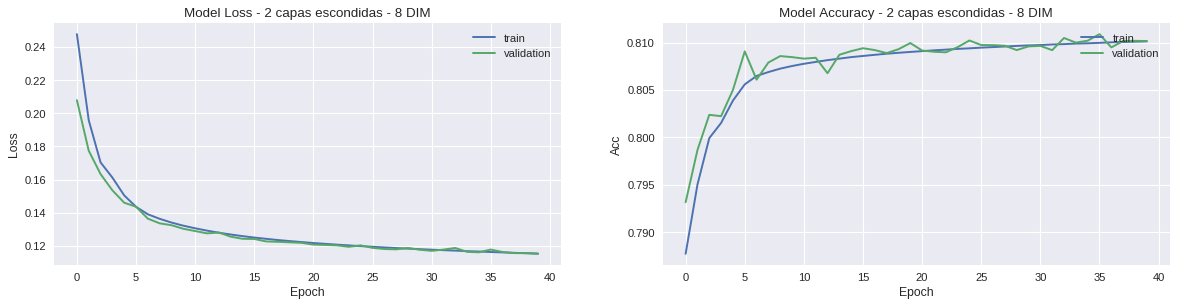

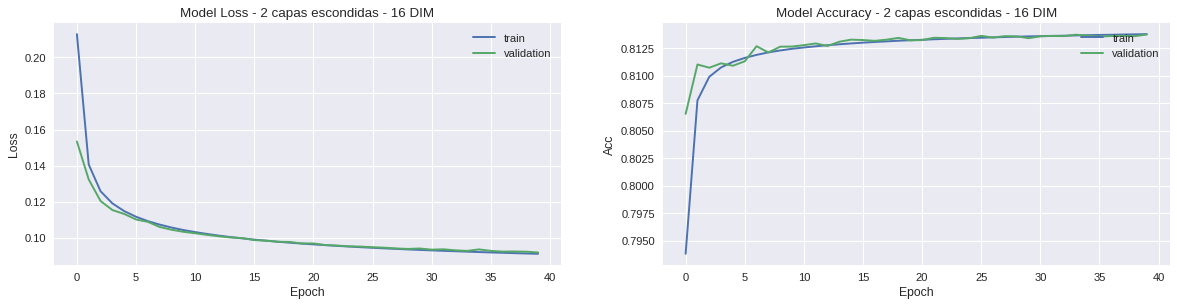

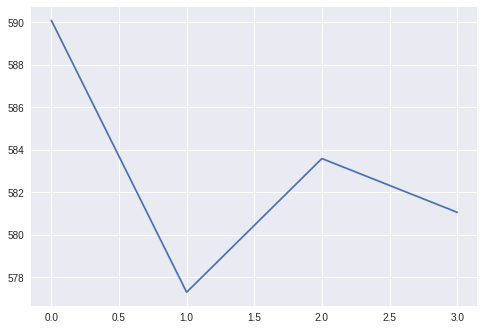

In [48]:
for i in range(len(history_1_d_1_list)):
  losses,accs = get_metrics_lists(history_1_d_1_list[i])
  triple_plot(losses,accs,'Model Loss - 2 capas escondidas - '+str(dims[i])+' DIM')

plt.plot(times_d_1)

* A pesar de que el loss obtenido se mantiene similar, podemos notar como a medida que se aumenta la dimensión, el comportamiento para la validación se muestra menos variable y cercano al error de entrenamiento.  Como se comento previamente ahora se debe hacer la comparación con *PCA* con la misma cantidad de componentes o dimensiones.

In [0]:

i=0
for dim in dims:
  print("============================ Comparación encoder vs PCA para dimensión de tamaño " + str(dim) + " ============================")
  pca_1_c = PCA(n_components=dim)
  pca_1_c.fit(x_train)
  pca_train_1_c = pca_1_c.transform(x_train)
  pca_test_1_c = pca_1_c.transform(x_test)
  #AUTOENCODER
  encoded_train_1_c = encoder_1_a_2_list[i].predict(x_train)
  encoded_test_1_c = encoder_1_a_2_list[i].predict(x_test)
  #CLASIFICATION
  clf_1_c = KNeighborsClassifier(10)
  clf_1_c.fit(pca_train_1_c, y_train)
  print('Classification Accuracy PCA: ' + str(clf_1_c.score(pca_test_1_c,y_test))) 
  clf_1_c = KNeighborsClassifier(10)
  clf_1_c.fit(encoded_train_1_c, y_train)
  print('Classification Accuracy Encoder: ' + str(clf_1_c.score(encoded_test_1_c,y_test)))
  i+=1

#### 2.1.d.2 3 capas escondidas

#### 2.1.d.1 4 capas escondidas

In [0]:
    pca = PCA(n_components=target_dim)
    pca.fit(x_train)

### 2.1.e Visualización con TSNE

Con los resultados obtenidos entrenando deep autoencoders, 

In [0]:
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot]
                                
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA
... #plot AE (d=2) without TSNE
encoded_train = encoder2d.predict(x_train[:nplot]) #Autoencoder with d=2
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)                                

## 2.2 Denoising